<h2>Individual Exercise 1- Box Detection <br /></h2>
<h3>Authors: Melih Hasbi Ekinci <br /></h3>

In [22]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import cv2
from scipy import ndimage
from mpl_toolkits.mplot3d import Axes3D
from numpy.linalg import svd

<h4>1- Loading Data <br /></42>

In [2]:
data = loadmat('example1kinect.mat')
amplitude_image = data['amplitudes1']
distance_image = data['distances1']
point_cloud = data['cloud1']

In [3]:
amplitude_image.shape

(424, 512)

<h4>2- MLESAC and Preemptive RANSAC Implementation  <br /></42>

In [36]:
def MLESAC_plane_fit(point_cloud, epsilon=0.1, gamma=0.9, max_iterations=1000):
    best_cost = float('inf')
    best_plane = None
    best_inliers = None
    valid_points = point_cloud.reshape(-1, 3)[np.all(point_cloud.reshape(-1, 3) != 0, axis=1)]

    for _ in range(max_iterations):
        # Randomly sample three points
        sample_indices = np.random.choice(valid_points.shape[0], 3, replace=False)
        sample_points = valid_points[sample_indices]

        # Calculate plane parameters using the cross product of two vectors in the plane
        vec1 = sample_points[1] - sample_points[0]
        vec2 = sample_points[2] - sample_points[0]
        normal = np.cross(vec1, vec2)
        d = -np.dot(normal, sample_points[0])

        # Avoid division by zero in case of a degenerate sample
        if np.linalg.norm(normal) == 0:
            continue

        # Compute distances of all points to the plane
        distances = np.abs(np.dot(valid_points, normal) + d) / np.linalg.norm(normal)

        # Apply the MLESAC cost function
        cost = np.sum(np.where(distances < epsilon, distances, gamma))

        # Update best model if the current model is better
        if cost < best_cost:
            best_cost = cost
            best_plane = (normal, d)
            best_inliers = valid_points[distances < epsilon]

    return best_plane, best_inliers

def create_mask(point_cloud, inliers):
    reshaped_pc = point_cloud.reshape(-1, 3)
    mask = np.isin(reshaped_pc, inliers).all(axis=1).reshape(point_cloud.shape[0], point_cloud.shape[1])
    return mask
   

def extract_largest_component(mask):
    labeled_mask, num_features = ndimage.label(mask)
    component_sizes = ndimage.sum(mask, labeled_mask, range(num_features + 1))
    largest_component_label = component_sizes.argmax()
    return (labeled_mask == largest_component_label)

def visualize_mask(mask,cmap):
    plt.imshow(mask, cmap=cmap)
    plt.show()

def get_first_mask_mlesac(threshold,max_iterations,point_cloud):
    threshold = threshold  
    max_iterations = max_iterations 
    best_plane, inliers = MLESAC_plane_fit(point_cloud.reshape(-1,3), threshold, max_iterations)
    return best_plane,inliers

def get_second_mask_mlesac(mask,point_cloud,threshold,max_iterations):
    nonfloor_cloud = np.stack(((1-mask)*point_cloud[:,:,0], (1-mask)*point_cloud[:,:,1], (1-mask)*point_cloud[:,:,2]), axis=-1)
    threshold =threshold  
    max_iterations = max_iterations  
    best_plane_second, inliers_second = MLESAC_plane_fit(nonfloor_cloud.reshape(-1,3), threshold, max_iterations)
    # Now visualize the inliers (floor mask)
    mask_second=create_mask(nonfloor_cloud, inliers_second)
    # Clean up the mask using binary morphological operations
    cleaned_mask = ndimage.binary_opening(ndimage.binary_closing(mask_second))
    # Extract the largest connected component
    largest_component = extract_largest_component(cleaned_mask) 
    return largest_component, best_plane_second

def find_corners(mask):
    # Find contours
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Assuming the largest contour corresponds to the box top
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Approximate a polygon and get vertices
    epsilon = 0.1 * cv2.arcLength(largest_contour, True)
    corners = cv2.approxPolyDP(largest_contour, epsilon, True)
    
    return corners


def calculate_dimensions(corners):
    # Convert corners to convenient format
    corners = [corner[0] for corner in corners]
    # Calculate pairwise distances
    distances = [np.linalg.norm(np.array(corner1) - np.array(corner2)) for i, corner1 in enumerate(corners) for j, corner2 in enumerate(corners) if i < j]
    # Get the largest two distances
    width= np.average(sorted(list(set(distances)))[0:2])
    length= np.average(sorted(list(set(distances)))[2:4])
    return length, width, distances

def compute_distance_between_planes(best_plane,best_plane_second):
    # Ensure the planes are parallel by checking if their normal vectors are the same or in opposite directions
    normal_1 = best_plane[0]
    normal_2 = best_plane_second[0]
    d1=best_plane[1]
    d2=best_plane_second[1]

    # Compute the distance between the two planes
    distance = abs(d1 - d2) / np.linalg.norm(normal_1)

    return distance

def eroded_mask(mask):
    kernel_size = 5
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
    mask = mask.astype(np.uint8)
    eroded = cv2.erode(mask, kernel, iterations=1)
    return eroded

def dilated_mask(mask):
    kernel_size = 5
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
    mask = mask.astype(np.uint8)
    dilated = cv2.dilate(mask, kernel, iterations=5)
    return dilated

def opened_mask(mask):
    kernel_size = 5
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
    mask = mask.astype(np.uint8)
    opened = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    return opened

def closed_mask(mask):
    kernel_size = 5
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
    mask = mask.astype(np.uint8)
    closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return closed

def final_visualization(closed,largest_component,corners,image_shape):
    # Create an RGB representation
    combined_image = np.zeros(image_shape)

    # Set areas where the floor_mask is 1 to some color (e.g., white for this example)
    combined_image[closed == 1] = [ 0.3686, 0.7882, 0.3843]  # Change [1, 1, 1] to desired RGB values
    combined_image[closed == 0] = [0.1, 0.5, 0.9]  # Change [1, 1, 1] to desired RGB values

    # Set areas where the top_layer_mask is 1 to red
    combined_image[largest_component == 1] = [1, 0, 0]

    # Example corners for the box's top layer (replace with your corners)
    corners1 = corners.squeeze()

    # Plot
    fig, ax = plt.subplots()
    ax.imshow(combined_image)

    ax.plot([corners1[0][0], corners1[1][0]], [corners1[0][1], corners1[1][1]], 'b-',linewidth=3)  # Line between 1st and 2nd corner
    ax.plot([corners1[1][0], corners1[2][0]], [corners1[1][1], corners1[2][1]], 'b-',linewidth=3)  # Line between 2nd and 3rd corner
    ax.plot([corners1[2][0], corners1[3][0]], [corners1[2][1], corners1[3][1]], 'b-',linewidth=3)  # Line between 3rd and 4th corner
    ax.plot([corners1[3][0], corners1[0][0]], [corners1[3][1], corners1[0][1]], 'b-',linewidth=3)  # Line between 4th and 1st corner

    # Label the corners
    offset = 50  # Adjust this value as necessary

    ax.text(corners1[0][0], corners1[0][1] - offset, 'top', color='b', fontsize=10, ha='center', va='center')
    ax.text(corners1[1][0] - offset, corners1[1][1], 'left', color='b', fontsize=10, ha='center', va='center')
    ax.text(corners1[2][0], corners1[2][1] + offset, 'bottom', color='b', fontsize=10, ha='center', va='center')
    ax.text(corners1[3][0] + offset, corners1[3][1], 'right', color='b', fontsize=10, ha='center', va='center')

    plt.axis('off')
    plt.show()


In [37]:
### Helper functions for preemptive RANSAC

def fit_plane(points):
    """
    Fits a plane to a set of points using Singular Value Decomposition (SVD).
    The plane is defined as ax + by + cz + d = 0.
    """
    # Calculate centroid of the points
    centroid = np.mean(points, axis=0)

    # Subtract centroid from points to shift the points to the origin
    shifted_points = points - centroid

    # Use SVD to find the plane that minimizes the squared distance to the points
    _, _, vh = svd(shifted_points)
    normal = vh[2, :]

    # The equation of the plane is given by the dot product between normal and any point on the plane.
    # Since centroid is on the plane, the equation is normal . (point - centroid) = 0
    # Thus, d = -normal . centroid
    d = -np.dot(normal, centroid)

    # Return the plane parameters a, b, c, and d
    return np.append(normal, d)

def point_plane_distance(point, plane):
    """
    Calculates the distance from a point to a plane defined by ax + by + cz + d = 0.
    """
    # The distance from a point to a plane is given by the plane equation plugged into the point,
    # scaled by the inverse of the length of the normal vector to avoid scaling issues.
    a, b, c, d = plane
    normal_length = np.sqrt(a**2 + b**2 + c**2)
    return abs(a*point[0] + b*point[1] + c*point[2] + d) / normal_length

def get_inliers(points, plane, threshold):
    """
    Identifies points that are inliers to the provided plane within a given threshold.
    """
    return [point for point in points if point_plane_distance(point, plane) < threshold]

def f(i, M, B, N):
    # Preemption function as defined in the exercise screenshot
    return int(M**2 - (i*B)/N)

def get_inliers_indices(flat_point_cloud, plane, threshold):
    """
    Identifies indices of points that are inliers to the provided plane within a given threshold.
    """
    return np.array([i for i, point in enumerate(flat_point_cloud) if point_plane_distance(point, plane) < threshold])

# Corrected function to generate a mask for inliers based on the plane
def get_inliers_mask(point_cloud, plane, threshold):
    """
    Generates a boolean mask where inliers are marked as True based on the plane and threshold.
    """
    flat_point_cloud = point_cloud.reshape(-1, 3)
    inliers_indices = get_inliers_indices(flat_point_cloud, plane, threshold)
    inliers_mask = np.zeros(flat_point_cloud.shape[0], dtype=bool)
    inliers_mask[inliers_indices] = True
    return inliers_mask.reshape(point_cloud.shape[:-1])


In [38]:
def Preemptive_RANSAC_plane_fit(point_cloud, threshold, max_iterations, M, B):
    best_inliers = []
    best_plane = None
    N = point_cloud.shape[0]  # Number of points in the point cloud

    # Filter out invalid measurements (where z=0)
    valid_points = point_cloud[point_cloud[:, 2] != 0]

    # Preemptive RANSAC loop
    for i in range(max_iterations):
        hypotheses = []
        scores = []

        # Step 1: Generate M hypotheses
        for m in range(M):
            # Randomly select 3 points to fit the plane
            idx = np.random.choice(valid_points.shape[0], 3, replace=False)
            pts = valid_points[idx, :]
            # Fit plane to the 3 points
            plane = fit_plane(pts)
            hypotheses.append(plane)

        # Step 2: Evaluate hypotheses on a subset of B data points
        subset_indices = np.random.choice(valid_points.shape[0], B, replace=False)
        subset = valid_points[subset_indices]

        for plane in hypotheses:
            inliers = []
            for point in subset:
                distance = point_plane_distance(point, plane)
                if distance < threshold:
                    inliers.append(point)
            scores.append(len(inliers))

        # Step 3: Order hypotheses by their score
        ordered_indices = np.argsort(scores)[::-1]  # Sort in descending order
        top_indices = ordered_indices[:f(i, M, B, N)]  # Select top scoring hypotheses
        top_hypotheses = [hypotheses[j] for j in top_indices]

        # we will assume the top hypothesis is the best
        if top_hypotheses:
            best_plane = top_hypotheses[0]
            best_inliers = get_inliers(valid_points, best_plane, threshold)
            break 

    return best_plane, best_inliers

In [39]:
def get_first_mask_preemptive_ransac(threshold,max_iterations,point_cloud,M,B):
    threshold = threshold  
    max_iterations = max_iterations 
    best_plane, inliers = Preemptive_RANSAC_plane_fit(point_cloud.reshape(-1,3), threshold, max_iterations,M,B)
    return best_plane,inliers

def get_second_mask_preemptive_ransac(mask,point_cloud,threshold,max_iterations,M,B):
    nonfloor_cloud = np.stack(((1-mask)*point_cloud[:,:,0], (1-mask)*point_cloud[:,:,1], (1-mask)*point_cloud[:,:,2]), axis=-1)
    threshold =threshold  
    max_iterations = max_iterations  
    best_plane_second, inliers_second = Preemptive_RANSAC_plane_fit(nonfloor_cloud.reshape(-1,3), threshold, max_iterations,M,B)
    # Now visualize the inliers (floor mask)
    mask_second=create_mask(nonfloor_cloud, inliers_second)
    # Clean up the mask using binary morphological operations
    cleaned_mask = ndimage.binary_opening(ndimage.binary_closing(mask_second))
    # Extract the largest connected component
    largest_component = extract_largest_component(cleaned_mask) 
    return largest_component, best_plane_second

<h4>3- Visualization Preemptive RANSAC <br /></42>

M=5, B=100 points selected

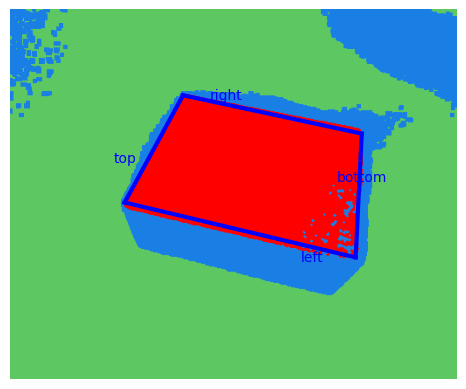

Length of the box is 240.67 and width of the box is 141.12
The height of the box is: 1701.08 units.


In [16]:
####Preemptive RANSAC
data = loadmat('example1kinect.mat')
point_cloud2 = data['cloud1']
best_plane, inliers=get_first_mask_preemptive_ransac(0.03,1000,point_cloud2,5,100)
mask=create_mask(point_cloud2, inliers)
largest_component, best_plane_second=get_second_mask_preemptive_ransac(mask,point_cloud2,0.01,1000,5,100)
closed=closed_mask(mask)
corners=find_corners(largest_component)
    
final_visualization(closed,largest_component,corners,point_cloud2.shape)
length, width,distances= calculate_dimensions(corners)

print('Length of the box is', format(length, '.2f'), 'and width of the box is', format(width, '.2f'))
height_of_box = compute_distance_between_planes(best_plane,best_plane_second)
print(f"The height of the box is: {format(height_of_box, '.2f')} units.")

M=10, B=100 points selected

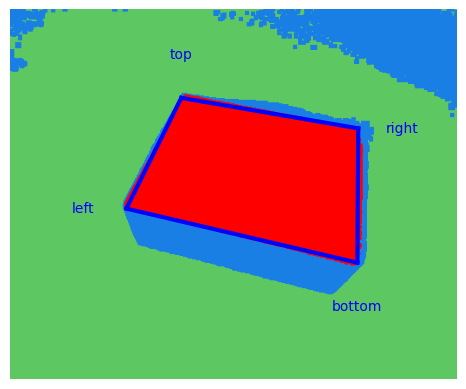

Length of the box is 239.08 and width of the box is 147.89
The height of the box is: 1.39 units.


In [17]:
####Preemptive RANSAC
data = loadmat('example1kinect.mat')
point_cloud2 = data['cloud1']
best_plane, inliers=get_first_mask_preemptive_ransac(0.03,1000,point_cloud2,10,100)
mask=create_mask(point_cloud2, inliers)
largest_component, best_plane_second=get_second_mask_preemptive_ransac(mask,point_cloud2,0.01,1000,10,100)
closed=closed_mask(mask)
corners=find_corners(largest_component)
final_visualization(closed,largest_component,corners,point_cloud2.shape)
length, width,distances= calculate_dimensions(corners)

print('Length of the box is', format(length, '.2f'), 'and width of the box is', format(width, '.2f'))
height_of_box = compute_distance_between_planes(best_plane,best_plane_second)
print(f"The height of the box is: {format(height_of_box, '.2f')} units.")

M=20, B=100 points selected

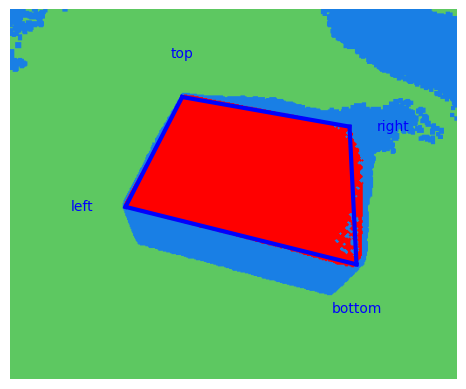

Length of the box is 233.98 and width of the box is 149.99
The height of the box is: 37.14 units.


In [41]:
####Preemptive RANSAC
data = loadmat('example1kinect.mat')
point_cloud2 = data['cloud1']
best_plane, inliers=get_first_mask_preemptive_ransac(0.03,1000,point_cloud2,20,100)
mask=create_mask(point_cloud2, inliers)
largest_component, best_plane_second=get_second_mask_preemptive_ransac(mask,point_cloud2,0.01,1000,50,100)
closed=closed_mask(mask)
corners=find_corners(largest_component)
final_visualization(closed,largest_component,corners,point_cloud2.shape)
length, width,distances= calculate_dimensions(corners)

print('Length of the box is', format(length, '.2f'), 'and width of the box is', format(width, '.2f'))
height_of_box = compute_distance_between_planes(best_plane,best_plane_second)
print(f"The height of the box is: {format(height_of_box, '.2f')} units.")

<h4>3- Visualization MLESAC <br /></42>

In [27]:
def compute_distance_between_planes(plane1, plane2):
    """
    Compute the distance between two parallel planes.
    :param plane1: coefficients of the first plane's equation (a, b, c, d)
    :param plane2: coefficients of the second plane's equation (a, b, c, d)
    :return: distance between the two planes
    """
    a, b, c, d1 = plane1
    _, _, _, d2 = plane2
    return abs(d2 - d1) / np.sqrt(a**2 + b**2 + c**2)

In [35]:
best_plane_second

(array([-0.00145967,  0.02772406,  0.03957494]), -0.026370644374515945)

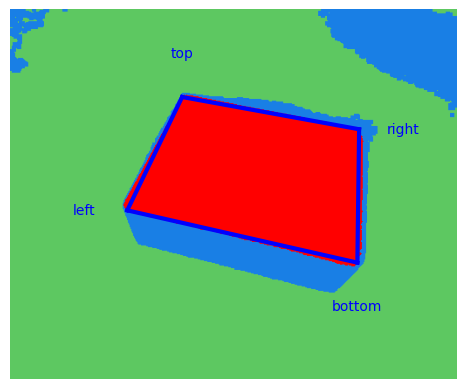

Length of the box is 238.54 and width of the box is 148.74
The height of the box is: 0.70 units.


In [40]:
#####MLESAC
data = loadmat('example1kinect.mat')
point_cloud2 = data['cloud1']
#Getting floor mask
best_plane, inliers=get_first_mask_mlesac(0.03,1000,point_cloud2)
# Now visualize the inliers (floor mask)
mask=create_mask(point_cloud2, inliers)
largest_component, best_plane_second=get_second_mask_mlesac(mask,point_cloud2,0.01,1000)
closed=closed_mask(mask)
corners=find_corners(largest_component)
final_visualization(closed,largest_component,corners,point_cloud2.shape)
length, width,distances= calculate_dimensions(corners)

print('Length of the box is', format(length, '.2f'), 'and width of the box is', format(width, '.2f'))
height_of_box = compute_distance_between_planes(best_plane,best_plane_second)
print(f"The height of the box is: {format(height_of_box, '.2f')} units.")

<h3>1.1 MLESAC Implementation Comments: <br /></h3>

I tried parameterers ranging from 0.000001 to 100 for both epsilon and gamma.<br />
Results looked almost same. This technique is quite surprising that parameter choice almost has no effect !<br />
This could be very advantegous in cloud point data where outliers are larger and threshold is difficult to seperate so that you don't have to try different parameters every time<br />
However, in our box pictures, I think results look quite similar with RANSAC because it is not very complex pictures.<br />
Maybe in more difficult pictures, we can see the performance of MLESAC better.<br />
To sum, MLESAC is advantegous in noisy data and also robust to outliers.<br />
Disadvantages of MLESAC is that it is slightly more complex than RANSAC as it involves calculating distances to all points. This computational complexity might not be exploited justifiedly if the data is small and sparse and not noisy.<br />


<h3>1.2 Preemptive RANSAC Implementation Comments: <br /></h3>
I tried parameters M=5,10,20 and B=100 for both floor and top layer of the box. I think top layer stays same for all choices of M. <br />
However, for the floor layer, it seems that low M performing poorly while it is better in M=10. When M=20, it performs slighlty worse again.<br />
Therefore, I think M>5 and M<20 is good interval for choice of M and I think parameter choice more important for floor layer.<br />
Main advantage of this approach is efficiency.. by eliminating unlikely hyptoheses, algorithm focuses on more promising candidates. Considering it only uses 100 data points.. and achieve same results with RANSAC.. a great success <br />
I think main disadvantage of this approach is its parameter sensivity.. it changes a lot when M is changed and also it does not guarantee optimal solution as its a heuristic.